<a href="https://colab.research.google.com/github/philjaycee/ML---CAP430/blob/main/ML_CAP_430.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import random
import tensorflow as tf
import shutil
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd

In [2]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/jctsfj2sfn-1.zip

--2021-05-29 07:00:39--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/jctsfj2sfn-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.21.211
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.21.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1437762638 (1.3G) [application/octet-stream]
Saving to: ‘jctsfj2sfn-1.zip’

jctsfj2sfn-1.zip    100%[===================>]   1.34G  29.8MB/s    in 48s     

2021-05-29 07:01:28 (28.5 MB/s) - ‘jctsfj2sfn-1.zip’ saved [1437762638/1437762638]



In [3]:
path_covid19 = f"jctsfj2sfn-1.zip"

local_zip = path_covid19
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [4]:
path_covid19 = f"covid19-pneumonia-normal-chest-xraypa-dataset.zip"

local_zip = path_covid19
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [5]:
!pip install split-folders
import splitfolders

In [6]:
splitfolders.ratio("/content/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/", output="/content/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/split2/", seed=1337, ratio=(0.80, 0.20))

Copying files: 4575 files [00:17, 256.93 files/s]


In [7]:
base_dir = "/content/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/split2/"

In [8]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

In [9]:
os.listdir(base_dir)

['val', 'train']

In [10]:
train_normal = os.path.join(train_dir, 'normal')
train_covid = os.path.join(train_dir, 'covid')
train_pneumonia = os.path.join(train_dir, 'pneumonia')

val_normal = os.path.join(validation_dir, 'normal')
val_covid = os.path.join(validation_dir, 'covid')
val_pneumonia = os.path.join(validation_dir, 'pneumonia')

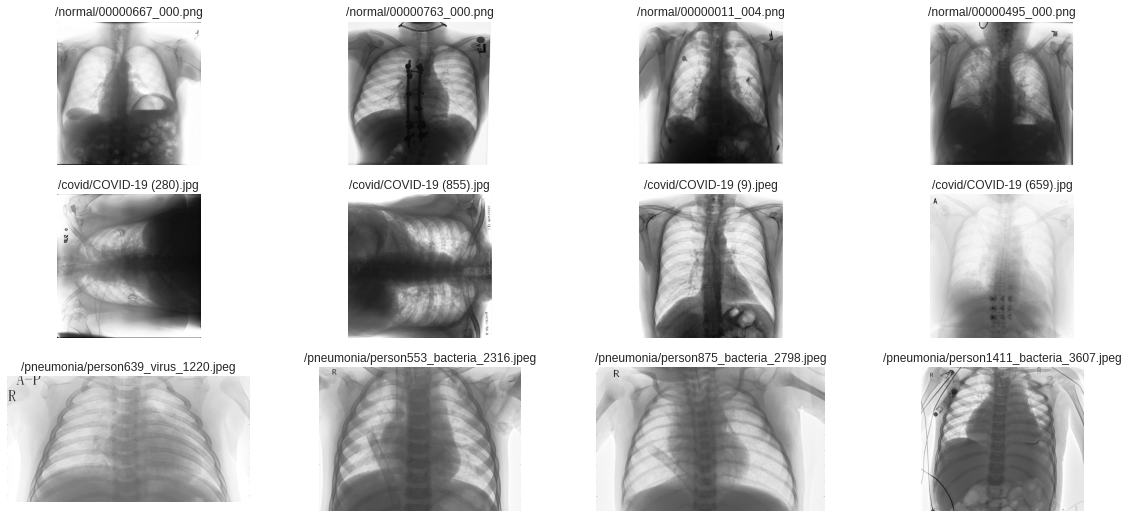

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as plt_image
plt.style.use("seaborn")
total = 4                                                                      
index = np.random.randint(20)                                                    

plt.figure(figsize=(5*total, 9))

list_normal = [os.path.join('/content/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/normal', name) for name in os.listdir('/content/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/normal')[index:index+total]]
list_covid = [os.path.join('/content/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/covid', name) for name in os.listdir('/content/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/covid')[index:index+total]]
list_pneumonia = [os.path.join('/content/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/pneumonia', name) for name in os.listdir('/content/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/pneumonia')[index:index+total]]



for i, path in enumerate(list_normal+list_covid+list_pneumonia):
  plt.subplot(3, total, i+1)
  plt.axis('off')

  plt.title(path.replace('/content/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset', ''))
  img = plt_image.imread(path)
  plt.imshow(img)

In [3]:
#Load training data
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

#Load testing data
test_datagen = ImageDataGenerator(
                    rescale=1./255,)

In [4]:
train_dir = "/content/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/split2/train/"
train_gen = train_datagen.flow_from_directory(
        train_dir,  # Training Directory
        target_size=(224, 224),  # Changing The Picture Resolution
        batch_size=3,
        
        class_mode='categorical')

validation_dir = "/content/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/split2/val/"
val_gen = test_datagen.flow_from_directory(
        validation_dir, # Validation Directory
        target_size=(224, 224), # Changing the picture resolution
        batch_size=3, 
        class_mode='categorical')

Found 3660 images belonging to 3 classes.
Found 915 images belonging to 3 classes.


In [5]:
train_gen.class_indices

{'covid': 0, 'normal': 1, 'pneumonia': 2}

In [108]:
 class myCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch,logs={}):
          print(logs.get('accuracy'))
          if (logs.get('accuracy')>0.9):
              print("Reached 90% accuracy so cancelling training!")
              self.model.stop_training=True

In [109]:
callbacks = myCallback()

In [110]:
from keras.layers import Dense, Activation
vgg16_model = tf.keras.applications.vgg16.VGG16()
vgg16_model.summary()
type(vgg16_model)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

tensorflow.python.keras.engine.functional.Functional

In [111]:
model = tf.keras.Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

In [112]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [113]:
model.pop()

In [114]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [115]:
for layer in model.layers:
    layer.trainable = False

In [116]:

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [117]:
model.add(Dense(3, activation = 'softmax'))

In [118]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [119]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [120]:

history = model.fit(
    train_gen,
    steps_per_epoch=10,
    epochs=100,
    validation_data=val_gen,
    validation_steps=5,
    verbose = 2,
    callbacks = [callbacks]
)

Epoch 1/100
10/10 - 26s - loss: 1.8283 - accuracy: 0.2333 - val_loss: 1.1975 - val_accuracy: 0.4667
0.23333333432674408
Epoch 2/100
10/10 - 25s - loss: 1.2192 - accuracy: 0.5667 - val_loss: 1.0734 - val_accuracy: 0.2667
0.5666666626930237
Epoch 3/100
10/10 - 25s - loss: 1.1852 - accuracy: 0.4000 - val_loss: 1.5692 - val_accuracy: 0.4667
0.4000000059604645
Epoch 4/100
10/10 - 25s - loss: 1.0385 - accuracy: 0.5333 - val_loss: 0.8210 - val_accuracy: 0.7333
0.5333333611488342
Epoch 5/100
10/10 - 25s - loss: 1.0095 - accuracy: 0.5000 - val_loss: 1.2275 - val_accuracy: 0.3333
0.5
Epoch 6/100
10/10 - 25s - loss: 0.9416 - accuracy: 0.5000 - val_loss: 1.2877 - val_accuracy: 0.4667
0.5
Epoch 7/100
10/10 - 24s - loss: 0.9218 - accuracy: 0.5667 - val_loss: 1.1451 - val_accuracy: 0.2667
0.5666666626930237
Epoch 8/100
10/10 - 25s - loss: 0.7370 - accuracy: 0.6667 - val_loss: 1.6038 - val_accuracy: 0.6000
0.6666666865348816
Epoch 9/100
10/10 - 24s - loss: 1.2196 - accuracy: 0.5667 - val_loss: 0.9170 

In [121]:
model.save('/content/model_ml.h5')

NotImplementedError: ignored

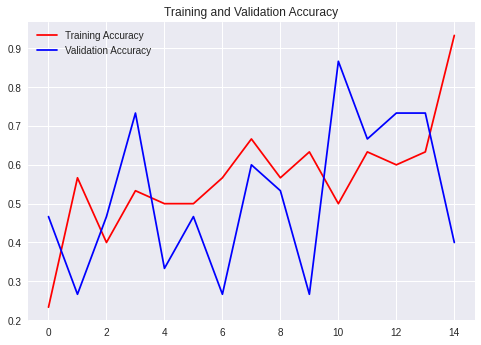

<Figure size 576x396 with 0 Axes>

In [122]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.plot(epochs, acc, "r", label="Training Accuracy")
plt.plot(epochs, val_acc, "b", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend(loc=0)


plt.figure()

plt.show()

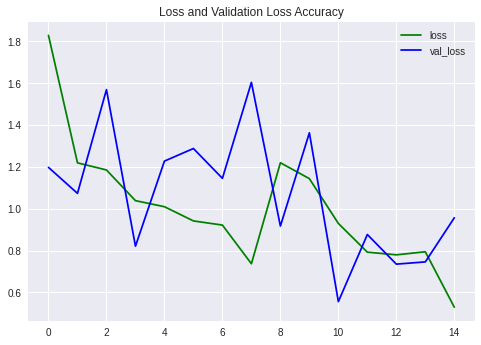

<Figure size 576x396 with 0 Axes>

In [123]:
epochs = range(len(acc))

plt.plot(epochs, loss, "g", label="loss")
plt.plot(epochs, val_loss, "b", label="val_loss")
plt.title("Loss and Validation Loss Accuracy")
plt.legend(loc=0)
plt.figure()

plt.show()

Saving person23_bacteria_90.jpeg to person23_bacteria_90.jpeg


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7fa1b64b5830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


[[0.5162545  0.00282799 0.48091754]]


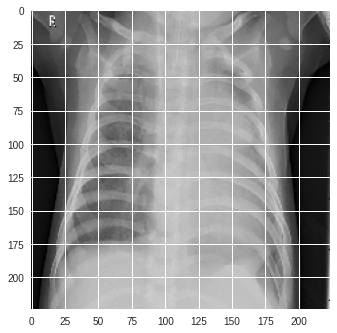

In [133]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  path = fn 
  img = image.load_img(path, target_size =(224,224))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

print(classes)
  #print(fn)
  #if classes[0][0] ==1:
  #  print('covid')
  #elif classes[0][1] ==1:
  #  print('normal')
  #elif classes[0][2] ==1:
  #  print('pneumonia')
  #else:
  #  print('tidak diketahui')
